In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# For Neural Network
try:
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    KERAS_AVAILABLE = True
except ImportError:
    KERAS_AVAILABLE = False
    print("TensorFlow not available. Will use only Logistic Regression.")

# Set random seed for reproducibility
np.random.seed(42)

# ==================== DATA LOADING AND PREPROCESSING ====================

def load_data(filepath='sentimentdataset.csv'):
    """Load the sentiment dataset"""
    try:
        df = pd.read_csv(filepath)
        print(f"Dataset loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns")
        return df
    except FileNotFoundError:
        print(f"Error: File '{filepath}' not found.")
        return None

def preprocess_text(text):
    """Clean and preprocess text data"""
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove special characters but keep emoticons
    text = re.sub(r'[^\w\s!?]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def map_sentiment_to_category(sentiment):
    """Map granular sentiments to Positive, Negative, or Neutral"""
    positive_emotions = ['positive', 'joy', 'happy', 'happiness', 'love', 'excited', 
                        'excitement', 'gratitude', 'grateful', 'hope', 'hopeful', 
                        'pride', 'proud', 'elation', 'euphoria', 'contentment', 
                        'serenity', 'empowerment', 'compassion', 'tenderness',
                        'enthusiasm', 'fulfillment', 'reverence', 'zest',
                        'playful', 'inspired', 'confident', 'free-spirited',
                        'empathetic', 'kind', 'admiration', 'affection', 'awe',
                        'adoration', 'anticipation', 'amusement', 'enjoyment',
                        'radiance', 'harmony', 'creativity', 'wonder', 'melodic',
                        'festive', 'accomplishment', 'satisfaction', 'blessed',
                        'optimism', 'thrill', 'adventure', 'mesmerizing']
    
    negative_emotions = ['negative', 'anger', 'angry', 'sadness', 'sad', 'fear', 
                        'fearful', 'hate', 'disgust', 'disappointed', 'disappointment',
                        'despair', 'grief', 'loneliness', 'jealousy', 'jealous',
                        'resentment', 'frustration', 'frustrated', 'boredom', 'bored',
                        'anxiety', 'anxious', 'intimidation', 'helplessness',
                        'envy', 'envious', 'regret', 'bitter', 'bitterness',
                        'devastated', 'dismissive', 'overwhelmed', 'apprehensive',
                        'heartbreak', 'betrayal', 'sorrow', 'darkness',
                        'desperation', 'desolation', 'isolation', 'suffering',
                        'shame', 'embarrassed']
    
    sentiment_lower = str(sentiment).lower().strip()
    
    if any(pos in sentiment_lower for pos in positive_emotions):
        return 'Positive'
    elif any(neg in sentiment_lower for neg in negative_emotions):
        return 'Negative'
    else:
        return 'Neutral'

def prepare_dataset(df):
    """Prepare dataset for analysis"""
    # Preprocess text
    df['Clean_Text'] = df['Text'].apply(preprocess_text)
    
    # Map sentiments to categories
    df['Sentiment_Category'] = df['Sentiment'].apply(map_sentiment_to_category)
    
    # Extract date components
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d-%m-%Y %H:%M', errors='coerce')
    df['Year'] = df['Timestamp'].dt.year
    df['Month'] = df['Timestamp'].dt.month
    df['Day'] = df['Timestamp'].dt.day
    df['Hour'] = df['Timestamp'].dt.hour
    
    # Count hashtags
    df['Hashtag_Count'] = df['Hashtags'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
    
    print("\nSentiment Distribution:")
    print(df['Sentiment_Category'].value_counts())
    
    return df

# ==================== SENTIMENT CLASSIFICATION ====================

def train_logistic_regression(X_train, X_test, y_train, y_test):
    """Train and evaluate Logistic Regression model"""
    print("\n" + "="*60)
    print("LOGISTIC REGRESSION MODEL")
    print("="*60)
    
    # Use class_weight to handle imbalanced data
    model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Evaluation
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    return model, y_pred, cm, accuracy, precision, recall, f1

def train_neural_network(X_train, X_test, y_train, y_test, input_dim, num_classes):
    """Train and evaluate Neural Network model"""
    if not KERAS_AVAILABLE:
        print("\nTensorFlow not available. Skipping Neural Network training.")
        return None, None, None, None, None, None, None
    
    print("\n" + "="*60)
    print("NEURAL NETWORK MODEL")
    print("="*60)
    
    # Encode labels
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)
    
    # Convert to categorical for multi-class
    if num_classes > 2:
        y_train_cat = keras.utils.to_categorical(y_train_encoded, num_classes)
        y_test_cat = keras.utils.to_categorical(y_test_encoded, num_classes)
        loss_fn = 'categorical_crossentropy'
        activation = 'softmax'
    else:
        y_train_cat = y_train_encoded
        y_test_cat = y_test_encoded
        loss_fn = 'binary_crossentropy'
        activation = 'sigmoid'
    
    # Build model
    model = Sequential([
        Dense(100, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(50, activation='relu'),
        Dropout(0.2),
        Dense(num_classes if num_classes > 2 else 1, activation=activation)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=loss_fn,
                  metrics=['accuracy'])
    
    # Train
    history = model.fit(X_train, y_train_cat, 
                       epochs=50, 
                       batch_size=32, 
                       validation_split=0.2,
                       verbose=0)
    
    # Predictions
    y_pred_prob = model.predict(X_test, verbose=0)
    
    if num_classes > 2:
        y_pred_encoded = np.argmax(y_pred_prob, axis=1)
    else:
        y_pred_encoded = (y_pred_prob > 0.5).astype(int).flatten()
    
    y_pred = le.inverse_transform(y_pred_encoded)
    
    # Evaluation
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    return model, y_pred, cm, accuracy, precision, recall, f1

# ==================== TREND ANALYSIS ====================

def analyze_trends(df):
    """Perform trend analysis on engagement metrics"""
    print("\n" + "="*60)
    print("TREND ANALYSIS")
    print("="*60)
    
    # Correlation analysis
    numeric_cols = ['Retweets', 'Likes', 'Hashtag_Count', 'Hour']
    correlation_matrix = df[numeric_cols].corr()
    
    print("\nCorrelation Matrix:")
    print(correlation_matrix)
    
    # Pearson correlation between Likes and Retweets
    likes_retweets_corr = df['Likes'].corr(df['Retweets'])
    print(f"\nPearson Correlation (Likes vs Retweets): {likes_retweets_corr:.4f}")
    
    # Posts per year
    posts_per_year = df.groupby('Year').size()
    print("\nPosts per Year:")
    print(posts_per_year)
    
    # Top hashtags
    all_hashtags = []
    for tags in df['Hashtags'].dropna():
        all_hashtags.extend(str(tags).split())
    
    from collections import Counter
    hashtag_counts = Counter(all_hashtags)
    top_hashtags = hashtag_counts.most_common(10)
    
    print("\nTop 10 Hashtags:")
    for tag, count in top_hashtags:
        print(f"{tag}: {count}")
    
    return correlation_matrix, posts_per_year, top_hashtags

# ==================== VISUALIZATION ====================

def plot_confusion_matrix(cm, labels, title):
    """Plot confusion matrix"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

def plot_trends(df, posts_per_year, top_hashtags):
    """Plot trend visualizations"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Posts per year
    axes[0, 0].bar(posts_per_year.index, posts_per_year.values, color='steelblue')
    axes[0, 0].set_title('Social Media Posts per Year')
    axes[0, 0].set_xlabel('Year')
    axes[0, 0].set_ylabel('Number of Posts')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # 2. Sentiment distribution
    sentiment_counts = df['Sentiment_Category'].value_counts()
    axes[0, 1].pie(sentiment_counts.values, labels=sentiment_counts.index, 
                   autopct='%1.1f%%', startangle=90)
    axes[0, 1].set_title('Sentiment Distribution')
    
    # 3. Likes vs Retweets scatter
    axes[1, 0].scatter(df['Retweets'], df['Likes'], alpha=0.5, c='coral')
    axes[1, 0].set_title('Likes vs Retweets')
    axes[1, 0].set_xlabel('Retweets')
    axes[1, 0].set_ylabel('Likes')
    axes[1, 0].grid(alpha=0.3)
    
    # 4. Top hashtags
    tags, counts = zip(*top_hashtags[:10])
    axes[1, 1].barh(range(len(tags)), counts, color='teal')
    axes[1, 1].set_yticks(range(len(tags)))
    axes[1, 1].set_yticklabels(tags)
    axes[1, 1].set_title('Top 10 Hashtags')
    axes[1, 1].set_xlabel('Frequency')
    axes[1, 1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()

# ==================== MAIN EXECUTION ====================

def main():
    print("="*60)
    print("SOCIAL MEDIA SENTIMENT & TREND ANALYSIS")
    print("="*60)
    
    # Load data
    df = load_data('sentimentdataset.csv')
    if df is None:
        return
    
    # Prepare dataset
    df = prepare_dataset(df)
    
    # For binary classification (Positive vs Negative only)
    df_binary = df[df['Sentiment_Category'].isin(['Positive', 'Negative'])].copy()
    print(f"\nBinary classification dataset: {df_binary.shape[0]} samples")
    
    # TF-IDF Vectorization
    print("\nPerforming TF-IDF vectorization...")
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    X = vectorizer.fit_transform(df_binary['Clean_Text'])
    y = df_binary['Sentiment_Category']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    # Train Logistic Regression
    lr_model, lr_pred, lr_cm, lr_acc, lr_prec, lr_rec, lr_f1 = train_logistic_regression(
        X_train, X_test, y_train, y_test
    )
    
    # Train Neural Network
    labels = sorted(y.unique())
    nn_model, nn_pred, nn_cm, nn_acc, nn_prec, nn_rec, nn_f1 = train_neural_network(
        X_train.toarray(), X_test.toarray(), y_train, y_test, 
        input_dim=X_train.shape[1], num_classes=len(labels)
    )
    
    # Trend Analysis
    correlation_matrix, posts_per_year, top_hashtags = analyze_trends(df)
    
    # Summary Table
    print("\n" + "="*60)
    print("MODEL PERFORMANCE SUMMARY")
    print("="*60)
    print(f"{'Model':<25} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
    print("-"*73)
    print(f"{'Logistic Regression':<25} {lr_acc:<12.4f} {lr_prec:<12.4f} {lr_rec:<12.4f} {lr_f1:<12.4f}")
    if KERAS_AVAILABLE and nn_acc:
        print(f"{'Neural Network':<25} {nn_acc:<12.4f} {nn_prec:<12.4f} {nn_rec:<12.4f} {nn_f1:<12.4f}")
    
    # Visualizations
    print("\nGenerating visualizations...")
    
    # Confusion matrix for Logistic Regression
    plot_confusion_matrix(lr_cm, labels, 'Confusion Matrix - Logistic Regression')
    
    if KERAS_AVAILABLE and nn_cm is not None:
        # Confusion matrix for Neural Network
        plot_confusion_matrix(nn_cm, labels, 'Confusion Matrix - Neural Network')
    
    # Trend plots
    plot_trends(df, posts_per_year, top_hashtags)
    
    print("\n" + "="*60)
    print("ANALYSIS COMPLETE")
    print("="*60)

SOCIAL MEDIA SENTIMENT & TREND ANALYSIS
Dataset loaded successfully: 732 rows, 15 columns

Sentiment Distribution:
Sentiment_Category
Positive    365
Neutral     209
Negative    158
Name: count, dtype: int64

Binary classification dataset: 523 samples

Performing TF-IDF vectorization...
Training set: 418 samples
Test set: 105 samples

LOGISTIC REGRESSION MODEL

Accuracy: 0.9524
Precision: 0.9529
Recall: 0.9524
F1-Score: 0.9517

Classification Report:
              precision    recall  f1-score   support

    Negative       0.97      0.88      0.92        32
    Positive       0.95      0.99      0.97        73

    accuracy                           0.95       105
   macro avg       0.96      0.93      0.94       105
weighted avg       0.95      0.95      0.95       105


NEURAL NETWORK MODEL

Accuracy: 0.9429
Precision: 0.9426
Recall: 0.9429
F1-Score: 0.9423

Classification Report:
              precision    recall  f1-score   support

    Negative       0.93      0.88      0.90      

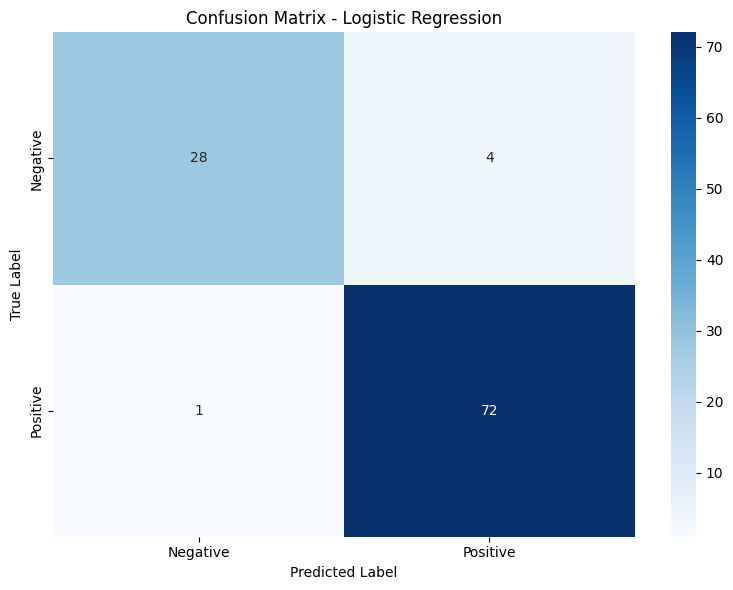

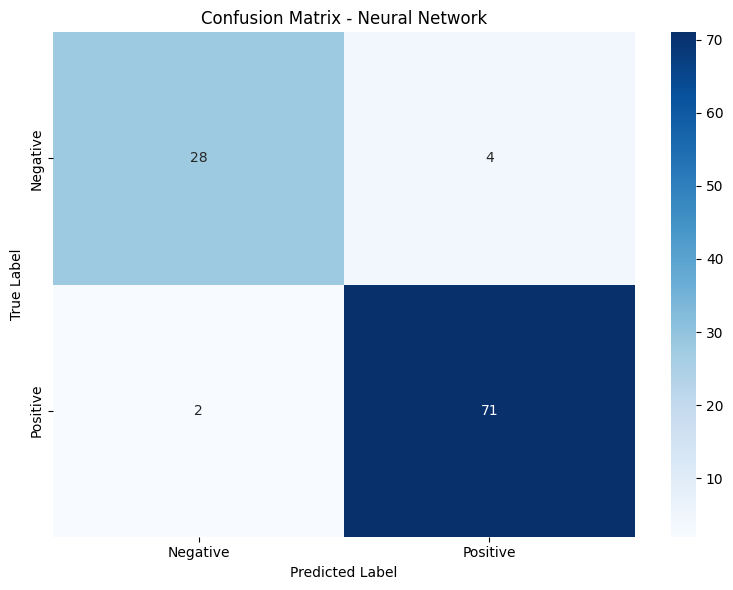

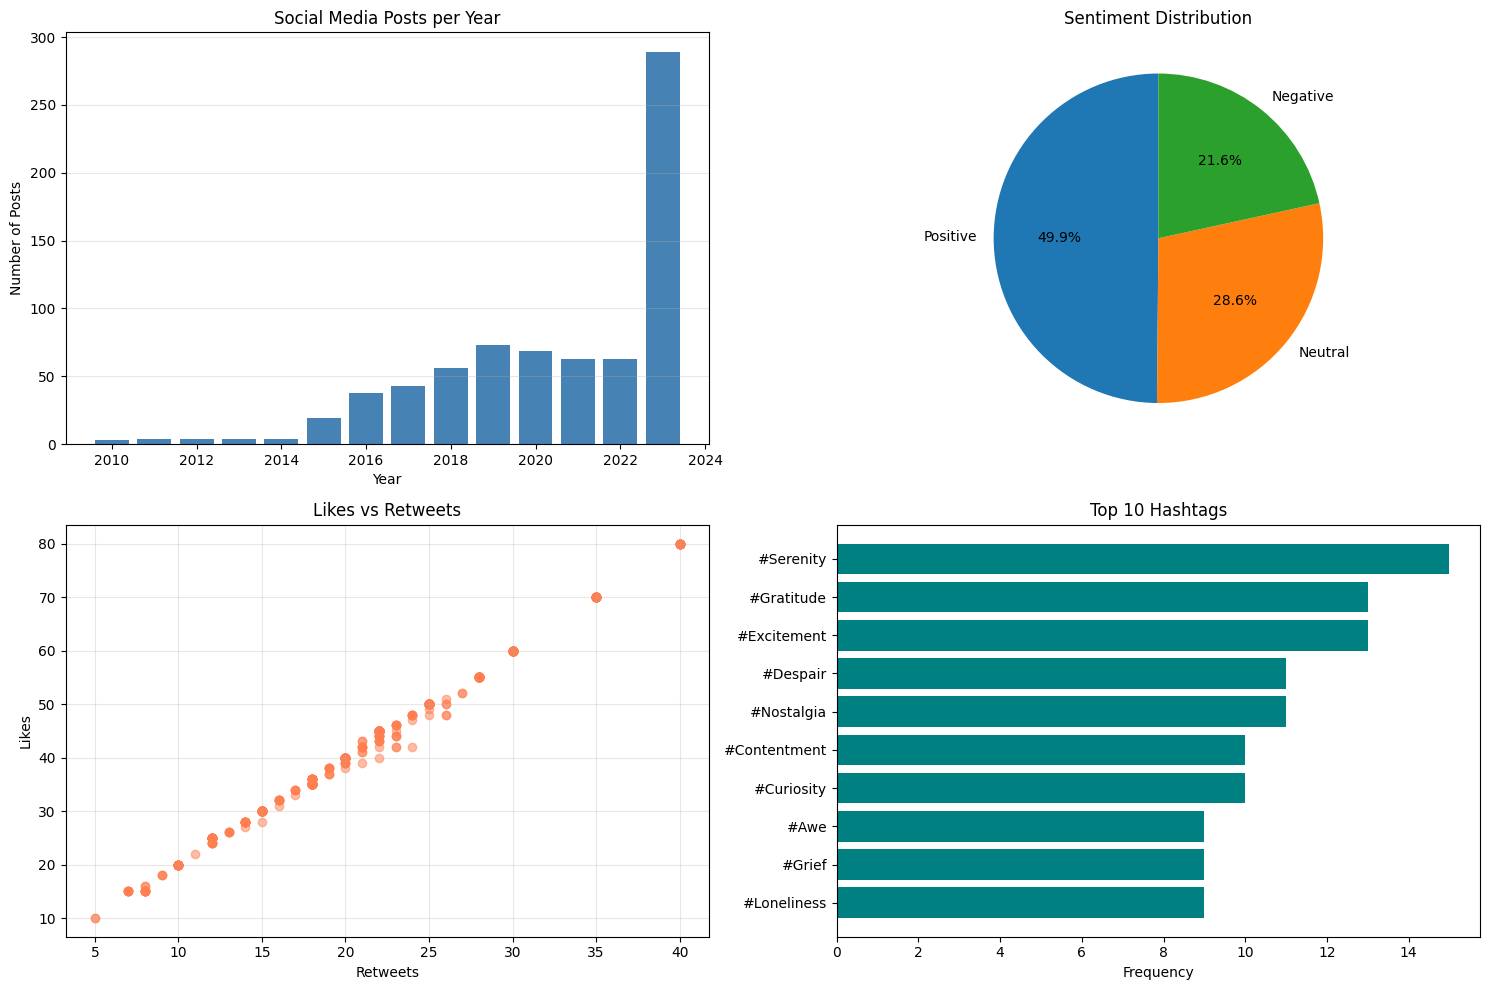


ANALYSIS COMPLETE


In [ ]:
if __name__ == "__main__":
    main()